# Fine Tuning A BERT Model With HuggingFace

## 1. Introduction

In [26]:
# !pip install arxiv
# !pip install evaluate

 Next I authenticate myself as my Google account user. This will be helpful since I will be storing the doccuments as json in [Google Cloud Storage](https://cloud.google.com/storage?hl=en) and authentication through [colab](https://colab.research.google.com/) means there's no extra steps for access to the data!

In [ ]:
import google.colab as colab
colab.auth.authenticate_user()

## 2. Collecting The Data

The first thing I need to do is collect data. In a [prior post](https://michael-harmon.com/blog/NLP1.html) I got documents for classification by collecting paper abstracts from [arxiv](https://arxiv.org/). I was going to reuse those same documents, but I lost them over the years. So, instead I'll use the [arixv package](https://lukasschwab.me/arxiv.py/arxiv.html) to create a new dataset for classification. Instead of 4 classes I'll use 3 and still make the datasets imbalanced. The 3 classes I'll use are the topics of the papers which I chose to be 'Artificial Intelligence', 'Information Retrieval' and 'Robotics'. 

First I collect 1,000 papers on 'Ariticial Intelligence', 1,000 papers on 'Information Retrieval' and 100 on 'Robotics' using a function I wrote called [get_data](utils.py).

In [ ]:
from utils import get_arxiv_data 

df = get_arxiv_data

An example of one document is below,

In [20]:
ai_results[0]

{'id': 'http://arxiv.org/abs/cs/9308101v1',
 'code': 'cs.AI',
 'text': 'Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.'}

Now we combine them into a dataframe,

Now looking at the contents of the dataframe,

In [14]:
df.head(2)

,id,code,text
0,http://arxiv.org/abs/cs/9308101v1,cs.AI,Because of their occasional need to return to ...
1,http://arxiv.org/abs/cs/9308102v1,cs.AI,Market price systems constitute a well-underst...


The `id` is the url of the paper, the `code` is the class label and `text` is the abstract of the paper.

I want to be able to predict the category of the abstract based of the text. This means we need to conver the category into a numerical value. [Scikit-learn's LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) is the tool for the job,

In [ ]:
from sklearn.preprocessing import LabelEncoder

labeler  = LabelEncoder()
df = df.assign(label=labeler.fit_transform(df["code"]))

Now each text has an associated numerical value in the column `label` with values based on the `code` value,

In [17]:
df.head(2)

,id,code,text,label
0,http://arxiv.org/abs/cs/9308101v1,cs.AI,Because of their occasional need to return to ...,0
1,http://arxiv.org/abs/cs/9308102v1,cs.AI,Market price systems constitute a well-underst...,0


The numerical value for each code is given by the order in the `classes_` attribute of the labler. This means mapping between the code and the label can be found by the following,

In [19]:
{v:k for k,v in enumerate(labeler.classes_)}

{'cs.AI': 0, 'cs.IR': 1, 'cs.RO': 2}

Next I need to break the datasets into train, validation and test sets. I can do this with [Scikit-Learn's train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                            df["text"],
                                            df["label"],
                                            test_size=0.15,
                                            random_state=42,
                                            stratify=df["label"])

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.20,
                                                  random_state=42,
                                                  stratify=y_train)

The size of the datsets are,

In [42]:
X_train.shape, X_val.shape, X_test.shape

((1428,), (357,), (315,))

These are small datasets, but luckily using finetuning a high peforming model can still be obtained! While Scikit-Learn uses stratified sampling by default, I should check to make sure the distribution of class lablels is consistent between train, validation and test sets.

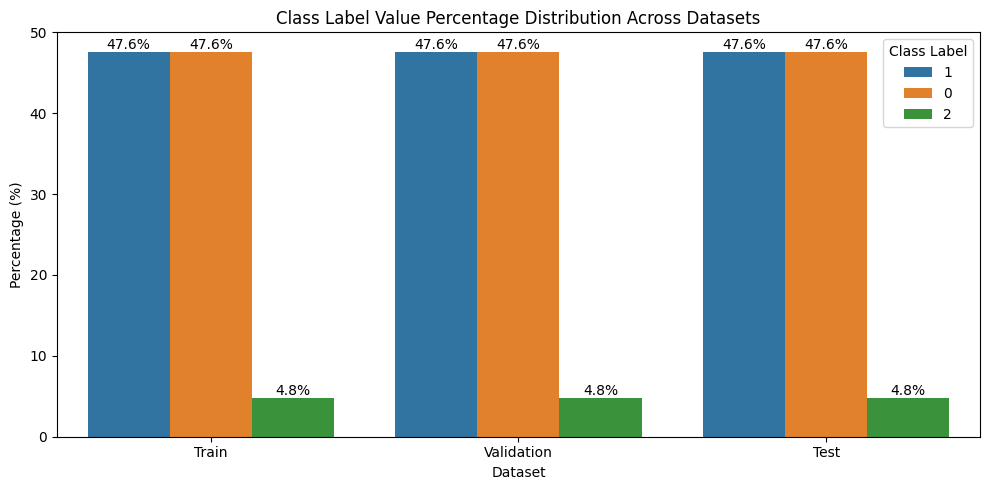

In [47]:
from utils import plot_target_distribution_combined
plot_target_distribution_combined(train_df, val_df, test_df)

We can see that it is so the last thing to do before modeling is combine these back into one dataframe and save them to [Google Cloud Storage](https://cloud.google.com/storage?hl=en). This is necessary so I can come back to this project over time and still work with the same data.

In [ ]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
train_df.to_json("gs://harmon-arxiv/train_abstracts.json")

val_df   = pd.DataFrame({"text": X_val, "label": y_val})
val_df.to_json("gs://harmon-arxiv/val_abstracts.json")

test_df =  pd.DataFrame({"text": X_test, "label": y_test})
test_df.to_json("gs://harmon-arxiv/test_abstracts.json")

## 2. HuggingFace Models

Now that I have the data in Google Cloud Storage we begin the fine tuning of our model. 



First thing I do is import Pandas for reloading the data from cloud storage, and the necessary PyTorch and Hugging Face modules.

In [45]:
import pandas as pd

# PyTorch imports
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

# Hugging Face imports
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import evaluate

Now I can load the datasets from cloud storage as Pandas dataframes and then convert them to [Hugging Face Datasets](https://huggingface.co/docs/datasets/en/index) so they can be used by the Transformer model:

In [10]:
train_df = pd.read_json("gs://harmon-arxiv/train_abstracts.json")
val_df = pd.read_json("gs://harmon-arxiv/val_abstracts.json")
test_df = pd.read_json("gs://harmon-arxiv/test_abstracts.json")

Then conver them to Dataset objects:

In [11]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

Finally I will combine them into a [DatasetDict](https://huggingface.co/docs/datasets/v4.0.0/en/package_reference/main_classes#datasets.DatasetDict) obect. This is not necessary, but it is convenient since applying a transformation to the DatasetDict applies it all the Datasets. This avoids repeating the same transformations individually across each datasets.

In [12]:
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

Next I download the [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) model from [HuggingFace's Model Hub](https://huggingface.co/models) as well as its associated Tokenizer. To do so, I use the [AutoTokenizer and AutoModelForSequenceClassification classes](https://huggingface.co/docs/transformers/en/model_doc/auto) as they allow me to swap out models easily. Notice that the tokenizer has to match the model and we have to use the [from_pretrained class methods](https://www.geeksforgeeks.org/python/classmethod-in-python/) for each class. This ensures that the tokenizer and weights for the model are both initialized from the same point in pre-training. Lastly, notice move the model to the GPU and that I have to put the number of classes in AutoModelForSequenceClassification during instantiation. This adds a linear layer with softmax on top of the foundational model.

In [56]:
checkpoint = "distilbert/distilbert-base-uncased"
device="cuda"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
type(model)

```
transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification
```

You can confirm the last layer by printing the model architecture

```
print(model)
```
which will return,


```
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=768, out_features=3072, bias=True)
            (lin2): Linear(in_features=3072, out_features=768, bias=True)
            (activation): GELUActivation()
          )
          (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        )
      )
    )
  )
  (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
  (classifier): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
```

The "classifier" layer is the head that was added and we can confirm that the output is 3 classes.

Next I load the metric to optimize the model using the [evaluate](https://huggingface.co/docs/evaluate/en/index) library. I chose a multiclass [ROC-AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric to measure the perofrmance of the model. This is a pretty standard metric for classification problems since it in essence measures "how well the model call separate the classes." Though it should be noted the ROC-AUC curve can be misleading when you have imbalanced classes as I discussed in a [prior post](https://michael-harmon.com/blog/NLP1.html).


In [57]:
roc_auc_score = evaluate.load("roc_auc", "multiclass")

Now that i have

In [58]:

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)



Map:   0%|          | 0/1428 [00:00<?, ? examples/s]

Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Map:   0%|          | 0/315 [00:00<?, ? examples/s]

In [59]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [60]:
tokenized_datasets = tokenized_datasets.remove_columns("text")
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [61]:
tokenized_datasets = tokenized_datasets.with_format("torch")

In [64]:
tokenized_datasets.num_rows

{'train': 1428, 'validation': 357, 'test': 315}

In [65]:
tokenized_datasets["test"].features


{'labels': Value('int64'),
 'input_ids': List(Value('int32')),
 'attention_mask': List(Value('int8'))}

In [66]:
val_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [68]:
from typing import Dict
import numpy as np

def calculate_roc_auc(
  model: transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification,
  loader: DataLoader
) -> Dict[str, np.float64]:

  roc_auc_score = evaluate.load("roc_auc", "multiclass")
  model.eval()
  for batch in loader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)
          scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
          roc_auc_score.add_batch(references=batch["labels"],
                                prediction_scores=scores)

  return roc_auc_score.compute(multi_class="ovr")

In [69]:
calculate_roc_auc(model, val_dataloader)

{'roc_auc': np.float64(0.4807119639299569)}

{'roc_auc': np.float64(0.6150256894201531)}

## 3. Fine Tuning DistilBERT

In [24]:
model.device

device(type='cuda', index=0)

In [70]:
def compute_metrics(eval_preds):
    roc_auc_score = evaluate.load("roc_auc", "multiclass")
    preds, labels = eval_preds
    scores = torch.nn.functional.softmax(
                        torch.tensor(preds), dim=-1)

    return roc_auc_score.compute(prediction_scores=scores, references=labels, multi_class="ovr")

In [72]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    report_to="none"
)

In [75]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
output = trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,0.421300,0.461289,0.968239
2,0.220400,0.460888,0.961172
3,0.203400,0.396393,0.977058


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.421300,0.461289,0.968239
2,0.220400,0.460888,0.961172
3,0.203400,0.396393,0.977058


In [33]:
trainer.save_model("temp")

In [ ]:
trainer.load   ("temp")

In [35]:
model = trainer.model


In [36]:
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

In [51]:
calculate_roc_auc(model, test_dataloader)

{'roc_auc': np.float64(0.972989898989899)}

In [52]:
trainer.create_model_card()